In [ ]:
import os
import numpy as np                                                                               
import pandas as pd                                                                              
import matplotlib.pyplot as plt                                                                  
import math                                                                                      
import cv2                                                                                       
import seaborn as sns                                                                            



import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              
from tensorflow.keras.models import Sequential                                                   
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                                 
from sklearn import preprocessing                                                               
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               

from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse     


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:

tf.keras.utils.set_random_seed(812)

tf.config.experimental.enable_op_determinism()

## Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/images-1.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [ ]:
print(images.shape)
print(labels.shape)

(1342, 128, 128, 3)
(1342, 1)


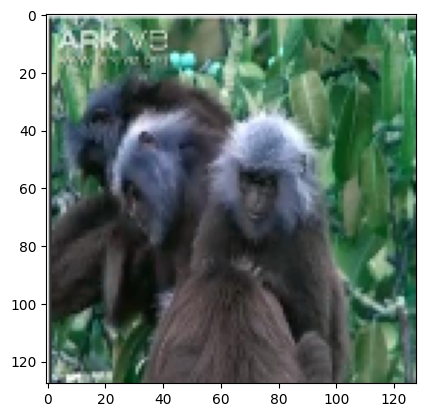

In [ ]:
plt.imshow(images[5])

In [ ]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      
  rows = 3                                                                        
  cols = 4                                                                        
  fig = plt.figure(figsize=(10, 8))                                               
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      
          ax.imshow(images[random_index, :])                                      
          ax.set_title(keys[random_index])
  plt.show()

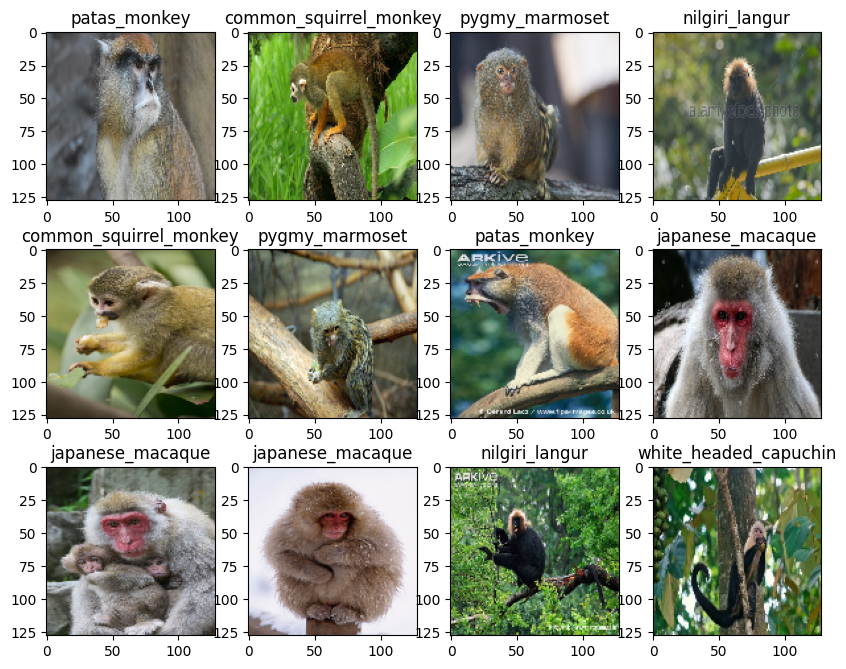

In [ ]:
plot_images(images,labels)

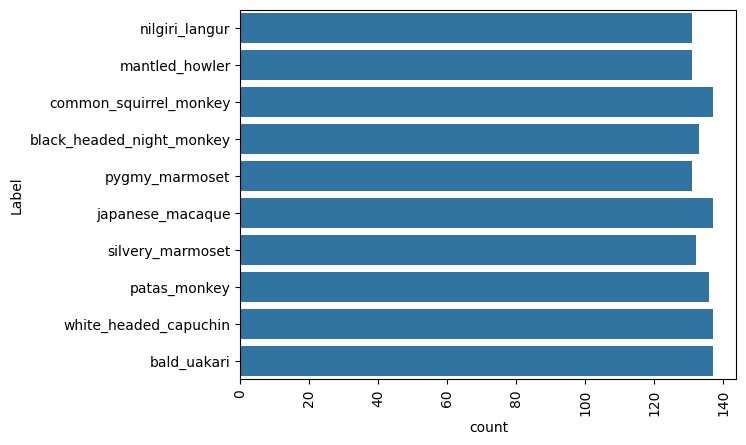

In [ ]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical');

### Resizing images

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

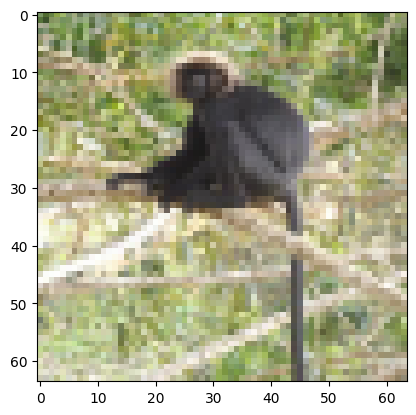

In [ ]:
plt.imshow(images_decreased[3]);

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(1073, 64, 64, 3) (1073, 1)
(134, 64, 64, 3) (134, 1)
(135, 64, 64, 3) (135, 1)


### Encoding the target labels

In [ ]:


from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

### Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target, ml=False):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) if ml else np.argmax(model.predict(predictors),axis=1)

    target = np.argmax(target,axis=1)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) if ml else np.argmax(model.predict(predictors),axis=1)

    target = np.argmax(target,axis=1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

## Model Building

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
#  freezing the layers
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model_1 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_1.add(vgg_model)

# Flattening the output of the VGG16 model
model_1.add(Flatten())

# Adding a dense output layer
model_1.add(Dense(10, activation='softmax'))

In [ ]:
opt=Adam()
# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 14735178 (56.21 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
train_datagen = ImageDataGenerator()

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = model_1.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
16/16 [==============================] - 3s 64ms/step - loss: 2.3524 - accuracy: 0.1635 - val_loss: 2.0789 - val_accuracy: 0.2313
Epoch 2/25
16/16 [==============================] - 1s 33ms/step - loss: 1.8499 - accuracy: 0.3925 - val_loss: 1.7712 - val_accuracy: 0.3657
Epoch 3/25
16/16 [==============================] - 1s 32ms/step - loss: 1.5850 - accuracy: 0.5292 - val_loss: 1.6203 - val_accuracy: 0.4701
Epoch 4/25
16/16 [==============================] - 1s 38ms/step - loss: 1.4203 - accuracy: 0.5699 - val_loss: 1.5186 - val_accuracy: 0.5000
Epoch 5/25
16/16 [==============================] - 1s 33ms/step - loss: 1.2869 - accuracy: 0.6224 - val_loss: 1.4438 - val_accuracy: 0.5224
Epoch 6/25
16/16 [==============================] - 1s 33ms/step - loss: 1.1960 - accuracy: 0.6543 - val_loss: 1.3825 - val_accuracy: 0.5373
Epoch 7/25
16/16 [==============================] - 1s 35ms/step - loss: 1.1239 - accuracy: 0.6838 - val_loss: 1.3443 - val_accuracy: 0.5672
Epoch 8/25
16

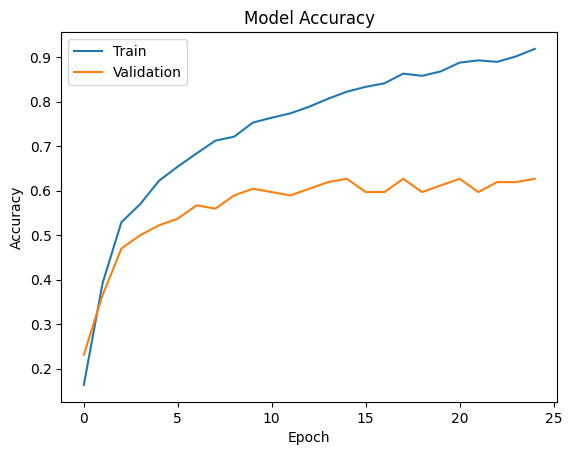

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_1_train_perf)

34/34 [==============================] - 1s 14ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.921715  0.921715   0.922623  0.921583


34/34 [==============================] - 0s 13ms/step


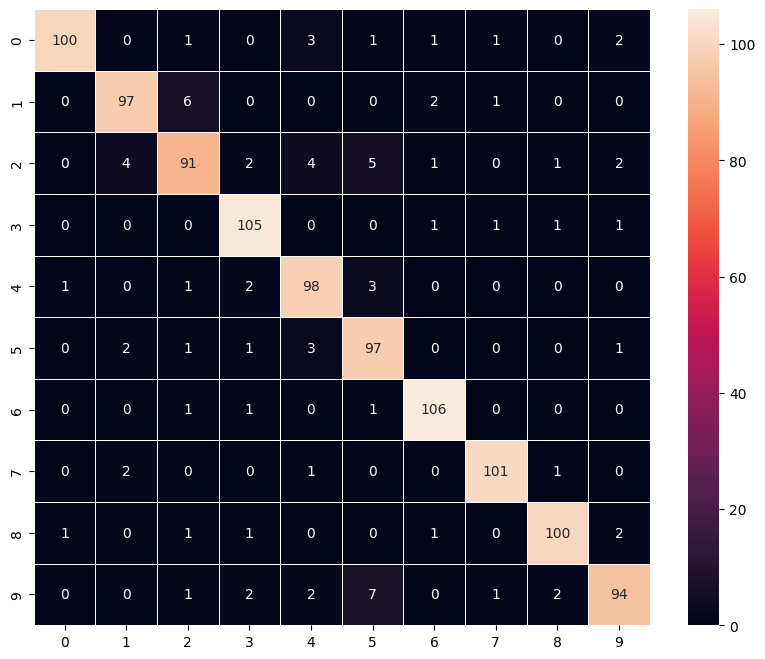

In [ ]:
plot_confusion_matrix(model_1,X_train_normalized,y_train_encoded)

In [ ]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_1_valid_perf)

5/5 [==============================] - 0s 12ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.626866  0.626866   0.629486    0.6217


5/5 [==============================] - 0s 13ms/step


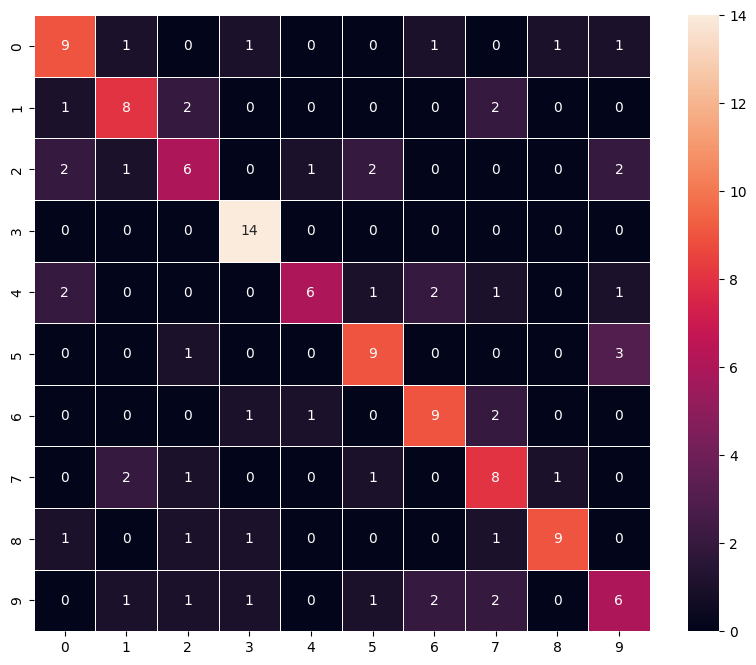

In [ ]:
plot_confusion_matrix(model_1,X_val_normalized,y_val_encoded)

#### Visualizing the prediction:

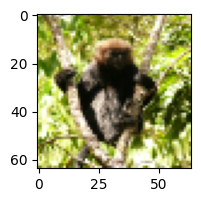

1/1 [==============================] - 0s 105ms/step
Predicted Label ['nilgiri_langur']
True Label bald_uakari


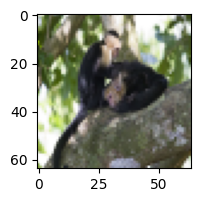

1/1 [==============================] - 0s 38ms/step
Predicted Label ['white_headed_capuchin']
True Label bald_uakari


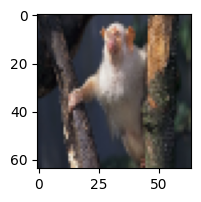

1/1 [==============================] - 0s 36ms/step
Predicted Label ['pygmy_marmoset']
True Label common_squirrel_monkey


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[2].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[33].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              
plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[36].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              

### Model 2 (VGG-16 (Base + FFNN))

- We will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten layer and a Feed Forward Neural Network.


In [ ]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

#Adding the Feed Forward neural network
model_2.add(Dense(256,activation='relu'))
model_2.add(Dropout(rate=0.4))
model_2.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_2.add(Dense(10, activation='softmax'))

In [ ]:
opt = Adam()

In [ ]:
# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 15247786 (58.17 MB)
Trainable params: 53

In [ ]:
history_vgg16 = model_2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
16/16 [==============================] - 4s 57ms/step - loss: 2.2743 - accuracy: 0.1566 - val_loss: 2.0821 - val_accuracy: 0.2164
Epoch 2/25
16/16 [==============================] - 1s 32ms/step - loss: 1.9169 - accuracy: 0.3023 - val_loss: 1.7624 - val_accuracy: 0.3507
Epoch 3/25
16/16 [==============================] - 1s 34ms/step - loss: 1.6643 - accuracy: 0.4238 - val_loss: 1.6013 - val_accuracy: 0.4627
Epoch 4/25
16/16 [==============================] - 1s 33ms/step - loss: 1.4164 - accuracy: 0.5215 - val_loss: 1.4509 - val_accuracy: 0.4925
Epoch 5/25
16/16 [==============================] - 1s 33ms/step - loss: 1.2657 - accuracy: 0.5818 - val_loss: 1.3962 - val_accuracy: 0.5224
Epoch 6/25
16/16 [==============================] - 1s 32ms/step - loss: 1.1411 - accuracy: 0.6165 - val_loss: 1.3334 - val_accuracy: 0.5522
Epoch 7/25
16/16 [==============================] - 1s 34ms/step - loss: 1.0217 - accuracy: 0.6620 - val_loss: 1.2651 - val_accuracy: 0.5746
Epoch 8/25
16

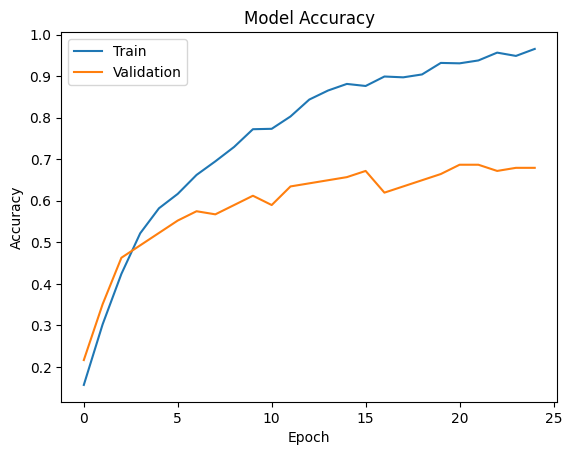

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf = model_performance_classification(model_2, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_2_train_perf)

34/34 [==============================] - 1s 13ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.996272  0.996272   0.996324  0.996272


34/34 [==============================] - 1s 14ms/step


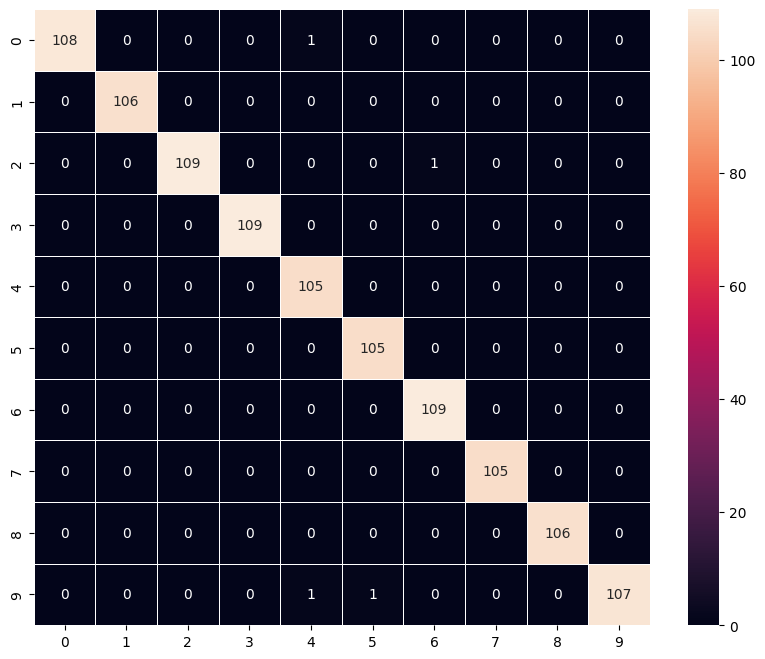

In [ ]:
plot_confusion_matrix(model_2,X_train_normalized,y_train_encoded)

In [ ]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_2_valid_perf)

5/5 [==============================] - 0s 12ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.679104  0.679104   0.681301  0.674771


5/5 [==============================] - 0s 12ms/step


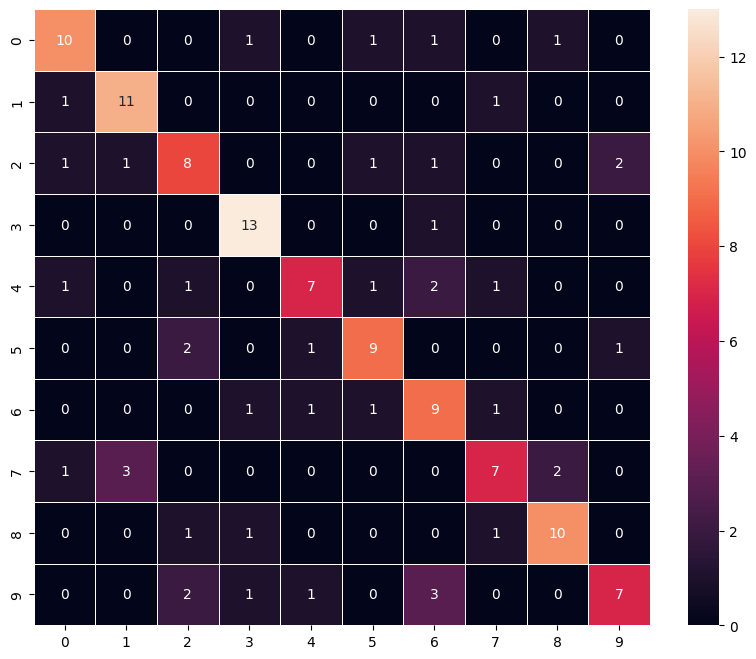

In [ ]:
plot_confusion_matrix(model_2,X_val_normalized,y_val_encoded)

#### Visualizing the prediction:

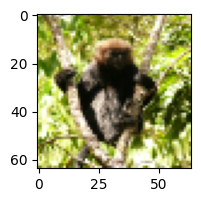

1/1 [==============================] - 0s 31ms/step
Predicted Label ['nilgiri_langur']
True Label bald_uakari


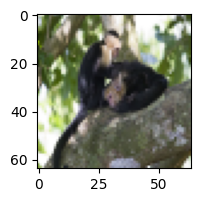

1/1 [==============================] - 0s 27ms/step
Predicted Label ['white_headed_capuchin']
True Label bald_uakari


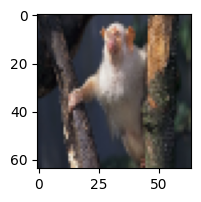

1/1 [==============================] - 0s 33ms/step
Predicted Label ['pygmy_marmoset']
True Label common_squirrel_monkey


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[2].reshape(1,64,64,3)))))   
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[33].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[36].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              

### Model 3 (VGG-16 (Base + FFNN + Data Augmentation)

In [ ]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(rate=0.4))
model_3.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(10, activation='softmax'))

In [ ]:
opt=Adam()
# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                8224      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 15247786 (58.17 MB)
Trainable params: 53

In [ ]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2,shear_range=0.3,zoom_range=0.4
                              )

In [ ]:
history_vgg16 = model_3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
16/16 [==============================] - 5s 162ms/step - loss: 2.3533 - accuracy: 0.1378 - val_loss: 2.2128 - val_accuracy: 0.2164
Epoch 2/25
16/16 [==============================] - 2s 114ms/step - loss: 2.2416 - accuracy: 0.1764 - val_loss: 2.1119 - val_accuracy: 0.2687
Epoch 3/25
16/16 [==============================] - 2s 111ms/step - loss: 2.1210 - accuracy: 0.2260 - val_loss: 1.8757 - val_accuracy: 0.3433
Epoch 4/25
16/16 [==============================] - 2s 117ms/step - loss: 2.0399 - accuracy: 0.2418 - val_loss: 1.8221 - val_accuracy: 0.3806
Epoch 5/25
16/16 [==============================] - 3s 202ms/step - loss: 1.9308 - accuracy: 0.3360 - val_loss: 1.6717 - val_accuracy: 0.4104
Epoch 6/25
16/16 [==============================] - 2s 113ms/step - loss: 1.8566 - accuracy: 0.3429 - val_loss: 1.6007 - val_accuracy: 0.4478
Epoch 7/25
16/16 [==============================] - 2s 111ms/step - loss: 1.8029 - accuracy: 0.3657 - val_loss: 1.5926 - val_accuracy: 0.4701
Epoch 

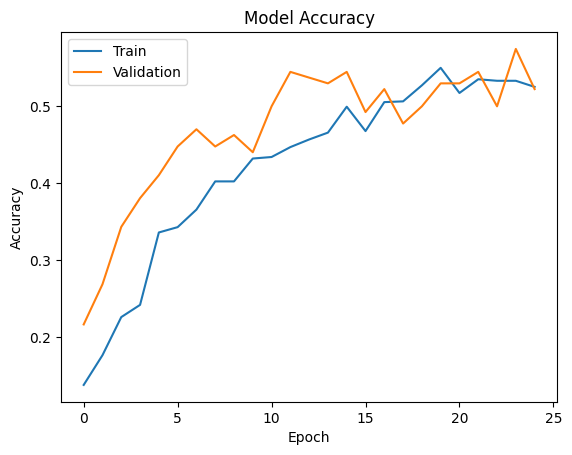

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_3_train_perf)

34/34 [==============================] - 1s 14ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.685927  0.685927    0.72222  0.676961


34/34 [==============================] - 0s 13ms/step


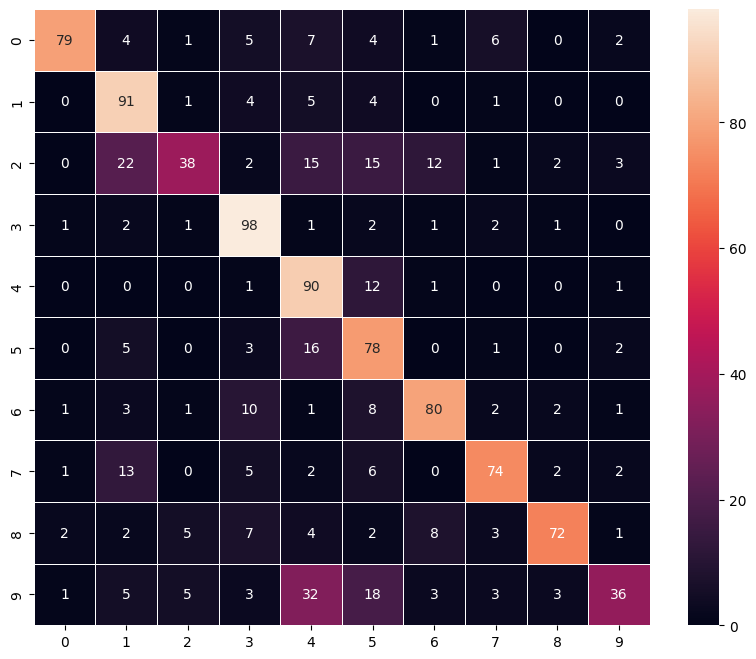

In [ ]:
plot_confusion_matrix(model_3,X_train_normalized,y_train_encoded)

In [ ]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_3_valid_perf)

5/5 [==============================] - 0s 12ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.522388  0.522388   0.560517  0.510285


5/5 [==============================] - 0s 12ms/step


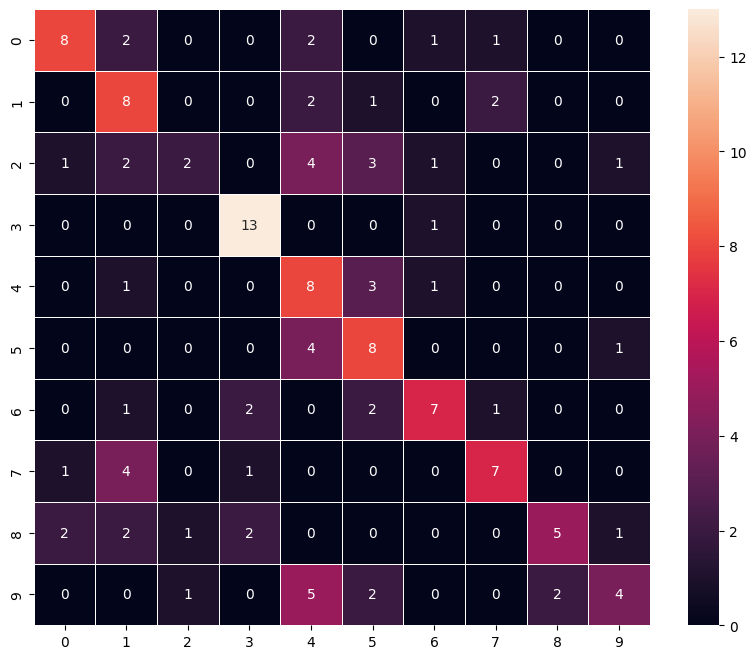

In [ ]:
plot_confusion_matrix(model_3,X_val_normalized,y_val_encoded)

#### Visualizing the prediction:

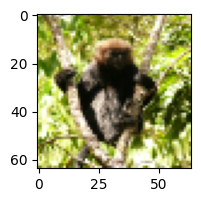

1/1 [==============================] - 0s 25ms/step
Predicted Label ['nilgiri_langur']
True Label bald_uakari


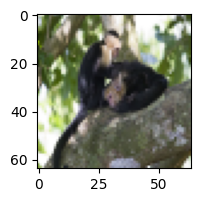

1/1 [==============================] - 0s 38ms/step
Predicted Label ['mantled_howler']
True Label bald_uakari


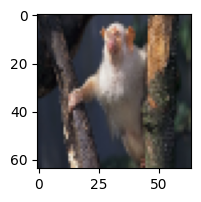

1/1 [==============================] - 0s 33ms/step
Predicted Label ['black_headed_night_monkey']
True Label common_squirrel_monkey


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[2].reshape(1,64,64,3)))))   
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[33].reshape(1,64,64,3))))) 
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                             
plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[36].reshape(1,64,64,3))))) 
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              

### Model 4 (VGG-16 Embeddings)

#### Generating Embeddings

In [ ]:
model = Sequential()

# Adding the convolutional part of the VGG16 model from above
model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model.add(Flatten())

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
embedding_matrix = np.ones(shape=(X_train_normalized.shape[0],2048))

total_images = X_train.shape[0]

for i in range(total_images):
    embedding_matrix[i] = model.predict(np.expand_dims(X_train_normalized[i],axis=0))

1/1 [==============================] - 0s 45ms/step


In [ ]:
print(embedding_matrix[0])

[0.92333502 0.         1.47779918 ... 0.58515602 0.58952409 0.        ]


#### Similarity Check

In [ ]:
Y = y_train.reset_index().drop('index',axis=1)

In [ ]:
Y

,Label
0,bald_uakari
1,mantled_howler
2,pygmy_marmoset
3,bald_uakari
4,patas_monkey
...,...
1068,bald_uakari
1069,patas_monkey
1070,silvery_marmoset
1071,black_headed_night_monkey


In [ ]:
def display(index_1,index_2):

    mse_val = mse(embedding_matrix[index_1].reshape(-1),embedding_matrix[index_2].reshape(-1))

    fig, axs = plt.subplots(1, 2)

    # Display the first image
    axs[0].imshow(X_train[index_1])
    axs[0].axis('off')  # Hide the axes
    axs[0].set_title(Y.iloc[index_1]["Label"])

    # Display the second image
    axs[1].imshow(X_train[index_2])
    axs[1].axis('off')  # Hide the axes
    axs[1].set_title(Y.iloc[index_2]["Label"])

    # Show the plot
    fig.suptitle("The MSE is "+str(mse_val))
    plt.show()

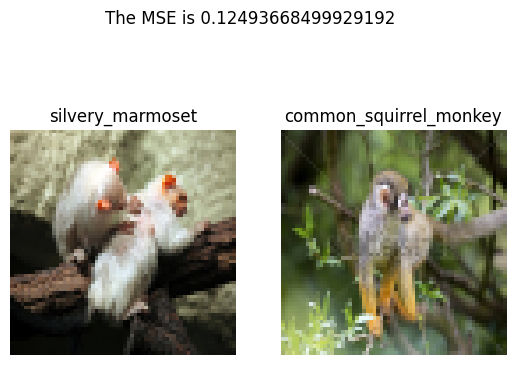

In [ ]:
display(785,923)

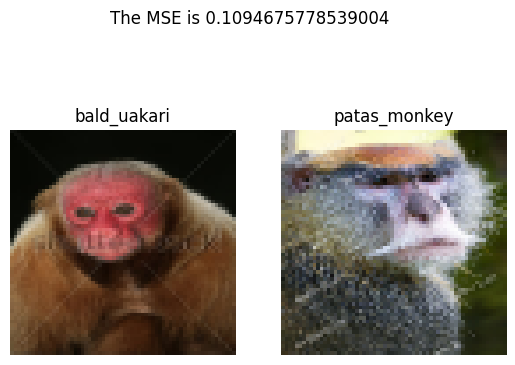

In [ ]:
display(0,4)

#### Machine Learning (SVM)

In [ ]:
from sklearn.svm import SVC

model_4 = SVC(kernel='rbf',C=0.5,probability=True)

model_4.fit(X_train_normalized.reshape(X_train_normalized.shape[0],-1), np.argmax(y_train_encoded,axis=1))

SVC(C=0.5, probability=True)

In [ ]:
model_4_train_perf = model_performance_classification(model_4,X_train_normalized.reshape(X_train_normalized.shape[0],-1), y_train_encoded,ml=True)

print("Train performance metrics")
print(model_4_train_perf)

Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.744641  0.744641    0.75897  0.742717


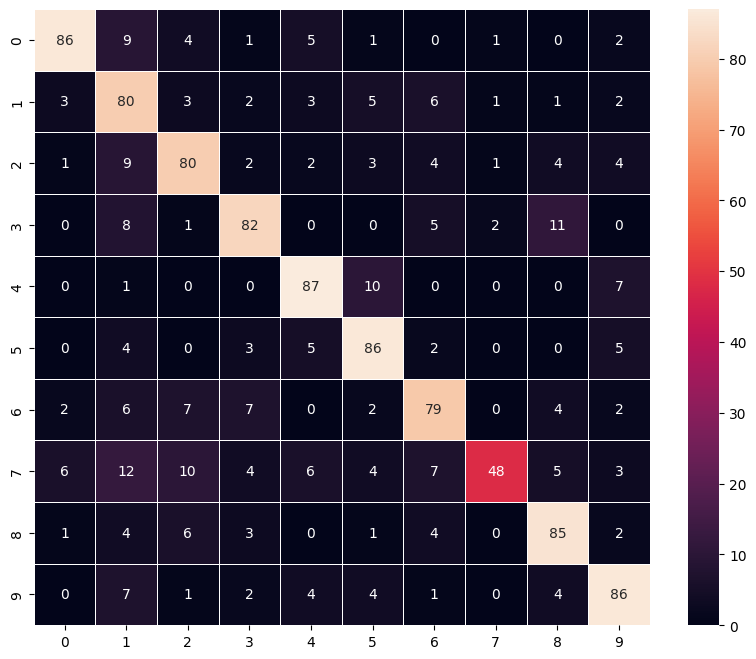

In [ ]:
plot_confusion_matrix(model_4,X_train_normalized.reshape(X_train_normalized.shape[0],-1), y_train_encoded,ml=True)

In [ ]:
model_4_valid_perf = model_performance_classification(model_4,X_val_normalized.reshape(X_val_normalized.shape[0],-1),y_val_encoded,ml=True)

print("Validation performance metrics")
print(model_4_valid_perf)

Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.589552  0.589552   0.588463  0.564177


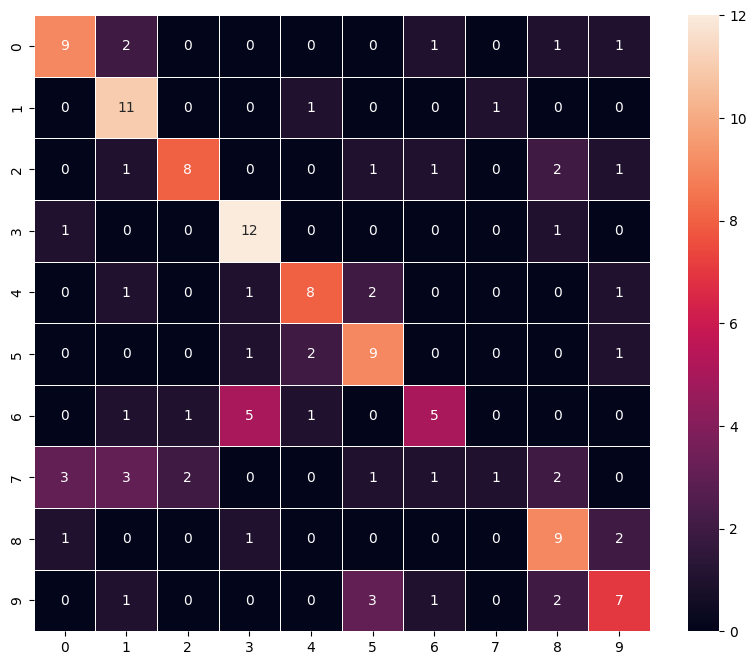

In [ ]:
plot_confusion_matrix(model_4,X_val_normalized.reshape(X_val_normalized.shape[0],-1),y_val_encoded,ml=True)

##### Visualizing the prediction:

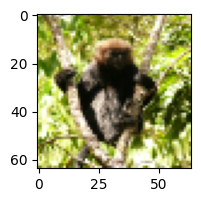

Predicted Label ['mantled_howler']
True Label bald_uakari


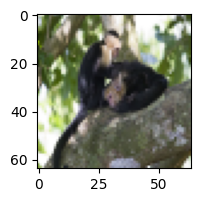

Predicted Label ['white_headed_capuchin']
True Label bald_uakari


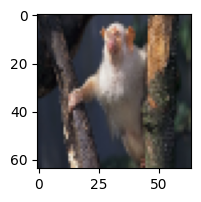

Predicted Label ['silvery_marmoset']
True Label common_squirrel_monkey


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict_proba(X_val_normalized[2].reshape(1,-1)))  )
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict_proba((X_val_normalized[33].reshape(1,-1)))) )
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict_proba((X_val_normalized[36].reshape(1,-1)))) )
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Model Performance Comparison and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)","SVM"
]

In [ ]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)","SVM"
]

In [ ]:
models_train_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug),SVM
Accuracy,0.921715,0.996272,0.685927,0.744641
Recall,0.921715,0.996272,0.685927,0.744641
Precision,0.922623,0.996324,0.722220,0.758970
F1 Score,0.921583,0.996272,0.676961,0.742717


In [ ]:
models_valid_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug),SVM
Accuracy,0.626866,0.679104,0.522388,0.589552
Recall,0.626866,0.679104,0.522388,0.589552
Precision,0.629486,0.681301,0.560517,0.588463
F1 Score,0.621700,0.674771,0.510285,0.564177


In [ ]:
models_train_comp_df - models_valid_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug),SVM
Accuracy,0.294849,0.317168,0.163539,0.155089
Recall,0.294849,0.317168,0.163539,0.155089
Precision,0.293138,0.315024,0.161703,0.170507
F1 Score,0.299884,0.321502,0.166675,0.178540


- We'll move ahead with the SVM model with VGG-16 embeddings as our final model.

### Test Performance

In [ ]:
model_4_test_perf = model_performance_classification(model_4, X_test_normalized.reshape(X_test_normalized.shape[0],-1),y_test_encoded,ml=True)

In [ ]:
model_4_test_perf

,Accuracy,Recall,Precision,F1 Score
0,0.437037,0.437037,0.406842,0.410183


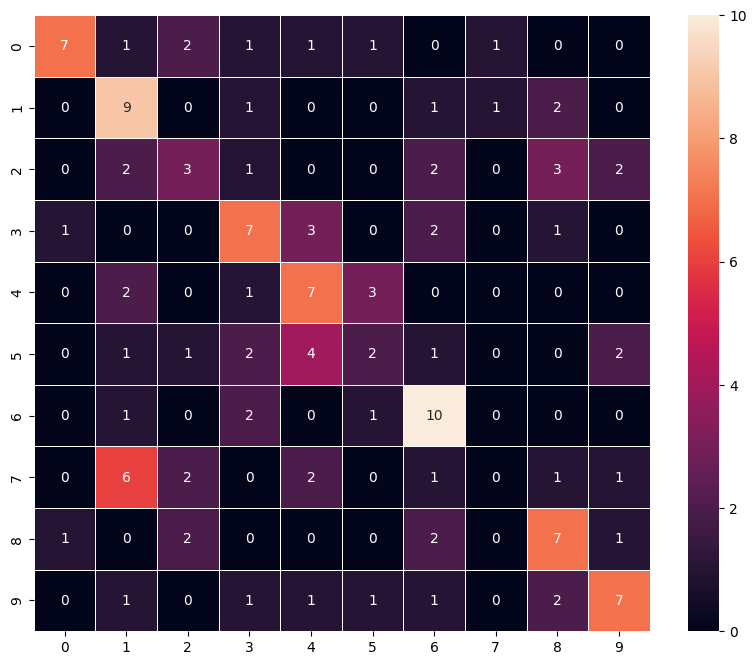

In [ ]:
plot_confusion_matrix(model_4, X_test_normalized.reshape(X_test_normalized.shape[0],-1),y_test_encoded,ml=True)